In [1]:
import pickle
import pandas as pd
import numpy as np
from tqdm import tqdm_notebook
import re
import ast
import string
import unidecode
from collections import defaultdict
from keras.models import Sequential, Model
from keras.preprocessing.sequence import pad_sequences
from keras.layers import Dense, LSTM, Embedding, concatenate, Input, Dropout
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, accuracy_score
from sklearn.utils import class_weight
from nltk import word_tokenize
from nltk.corpus import stopwords
import matplotlib.pyplot as plt
from sklearn import metrics

Using TensorFlow backend.


In [2]:
import tensorflow as tf
#import tf_sentencepiece
from tensorflow.keras import backend as K
import tensorflow_hub as hub
import os
from tokenization import FullTokenizer
from tqdm import tqdm_notebook

gpus = tf.config.experimental.list_physical_devices('GPU')
gpu = gpus[0]
tf.config.experimental.set_memory_growth(gpu, True)

In [3]:
bert_layer = hub.KerasLayer("https://tfhub.dev/tensorflow/bert_en_uncased_L-12_H-768_A-12/1")
#bert_layer = hub.Module("https://tfhub.dev/google/albert_xxlarge/2")
#bert_layer = hub.KerasLayer("https://tfhub.dev/google/albert_xxlarge/2")
                            
max_seq_length = 64

In [4]:
graph_train = np.load("../data/model1/bert_graph_train.npy")
graph_test = np.load("../data/model1/bert_graph_test.npy")

In [5]:
train_input_ids = np.load('../data/model1/bert_train_input_ids.npy')
train_input_masks = np.load('../data/model1/bert_train_input_masks.npy')
train_segment_ids = np.load('../data/model1/bert_train_segment_ids.npy')
train_labels = np.load('../data/model1/bert_train_labels.npy')

In [6]:
valid_input_ids = np.load('../data/model1/bert_valid_input_ids.npy')
valid_input_masks = np.load('../data/model1/bert_valid_input_masks.npy')
valid_segment_ids = np.load('../data/model1/bert_valid_segment_ids.npy')
valid_labels = np.load('../data/model1/bert_valid_labels.npy')

In [7]:
test_input_ids = np.load('../data/model1/bert_test_input_ids.npy')
test_input_masks = np.load('../data/model1/bert_test_input_masks.npy')
test_segment_ids = np.load('../data/model1/bert_test_segment_ids.npy')
test_labels = np.load('../data/model1/bert_test_labels.npy')

In [8]:
#only did train and validation because previously kernel died, so split it
X_train_input_ids = np.concatenate([train_input_ids, valid_input_ids])
X_train_input_masks = np.concatenate([train_input_masks, valid_input_masks])
X_train_segment_ids = np.concatenate([train_segment_ids, valid_segment_ids])
y_train = np.concatenate([train_labels, valid_labels])

In [9]:
# weights = class_weight.compute_class_weight('balanced',
#                                             [0, 1],
#                                             y_train)

In [10]:
input_word_ids = tf.keras.layers.Input(shape=(max_seq_length,), dtype=tf.int32,
                                       name="input_word_ids")
input_mask = tf.keras.layers.Input(shape=(max_seq_length,), dtype=tf.int32,
                                   name="input_mask")
segment_ids = tf.keras.layers.Input(shape=(max_seq_length,), dtype=tf.int32,
                                    name="segment_ids")
pooled_output, sequence_output = bert_layer([input_word_ids, input_mask, segment_ids])

input_graph = tf.keras.layers.Input(shape=(graph_train.shape[1],), dtype=tf.float32,
                                       name="input_graph")

w = tf.keras.layers.Concatenate()([pooled_output, input_graph])


w = tf.keras.layers.Dense(256, activation = 'relu')(w)
w = tf.keras.layers.Dropout(0.2)(w)
out = tf.keras.layers.Dense(1, activation = 'sigmoid')(w)
model = tf.keras.Model(inputs=[input_word_ids, input_mask, segment_ids, input_graph], outputs=out)
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_word_ids (InputLayer)     [(None, 64)]         0                                            
__________________________________________________________________________________________________
input_mask (InputLayer)         [(None, 64)]         0                                            
__________________________________________________________________________________________________
segment_ids (InputLayer)        [(None, 64)]         0                                            
__________________________________________________________________________________________________
keras_layer (KerasLayer)        [(None, 768), (None, 109482241   input_word_ids[0][0]             
                                                                 input_mask[0][0]             

In [11]:
# model.fit([lstm_train, graph_train, doc_train], y_train, batch_size = 256, epochs = 3, validation_split = 0.2)
# model.fit([X_train_input_ids[:10000], X_train_input_masks[:10000], X_train_segment_ids[:10000], graph_train[:10000]], y_train[:10000],
#           batch_size = 8192, epochs = 4, validation_split = 0.2)

model.fit([X_train_input_ids, X_train_input_masks, X_train_segment_ids, graph_train], y_train,
          batch_size = 2048, epochs = 4, validation_split = 0.2)

W1117 23:14:03.940298 139687751116608 deprecation.py:323] From /home/matteo/.local/lib/python3.7/site-packages/tensorflow/python/ops/math_grad.py:1250: add_dispatch_support.<locals>.wrapper (from tensorflow.python.ops.array_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


Train on 7490784 samples, validate on 1872697 samples
Epoch 1/4
7490784/7490784 [==============================] - 27454s 4ms/sample - loss: 0.3958 - accuracy: 0.8292 - val_loss: 0.3541 - val_accuracy: 0.8447
Epoch 2/4
7490784/7490784 [==============================] - 27436s 4ms/sample - loss: 0.3552 - accuracy: 0.8439 - val_loss: 0.3355 - val_accuracy: 0.8519
Epoch 3/4
7490784/7490784 [==============================] - 27271s 4ms/sample - loss: 0.3425 - accuracy: 0.8491 - val_loss: 0.3271 - val_accuracy: 0.8546
Epoch 4/4
7490784/7490784 [==============================] - 27219s 4ms/sample - loss: 0.3349 - accuracy: 0.8522 - val_loss: 0.3197 - val_accuracy: 0.8574


In [12]:
model.save('bert_model1.h5py')

In [ ]:
# y_test_pred = model.predict([lstm_test, graph_test, doc_test])
y_test_pred_prob = model.predict([test_input_ids, test_input_masks, test_segment_ids, graph_test])
y_test = test_labels
y_test_pred = np.where(y_test_pred_prob > 0.5, 1, 0)
accuracy_score(y_test, y_test_pred)

In [ ]:
cm = confusion_matrix(y_test, y_test_pred)

In [ ]:
from mlxtend.plotting import plot_confusion_matrix

plot_confusion_matrix(cm, show_normed = True);

In [ ]:
metrics.roc_auc_score(y_test, y_test_pred_prob)

In [ ]:
fpr, tpr, _ = metrics.roc_curve(y_test, y_test_pred_prob)

In [ ]:
plt.plot([0,1], [0,1], 'k--')
plt.plot(fpr, tpr)
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve')

In [ ]:
# see prediction score on candidate list

# find cutoff
# offset of where the true index is
cutoffs = [0]
for ind in test_idx:
    graph_inp = graph_input_list[ind]
    cutoffs.append(cutoffs[-1] + len(graph_inp))

In [ ]:
candidate_test_acc = .0
count = len(cutoffs) - 1
print_count = 100
for start_idx, end_idx in zip(cutoffs, cutoffs[1:]):
    probs = y_test_pred_prob[start_idx:end_idx]
    #if np.argmax(probs) == len(probs) - 1:
    if max(probs) == probs[-1]:
        if np.random.randint(sum(probs == probs[-1])) == 0:
            candidate_test_acc += 1
    else:
        if print_count:
            print(probs[-1], max(probs))
            print_count -= 1
candidate_test_acc /= count

In [ ]:
candidate_test_acc

In [ ]:
half_size = round(len(test_idx)/2)
abst_val_idx, abst_test_idx = test_idx[:half_size], test_idx[half_size:]
abst_val_cutoffs, abst_test_cutoffs = cutoffs[:half_size+1], cutoffs[half_size:]

In [ ]:
num_tr = 20
thresholds = 1./num_tr * np.arange(num_tr)

In [ ]:
recall_with_abstain = []
acc_after_abstain = []
abstain_rate = []
abst_val_count = len(abst_val_cutoffs) - 1
# abstain below the threshold
for tr in thresholds:
    recall = .0
    acc = .0
    abst = .0
    for start_idx, end_idx in zip(abst_val_cutoffs, abst_val_cutoffs[1:]):
        probs = y_test_pred_prob[start_idx:end_idx]
        max_prob = max(probs)
        if max_prob <= tr:
            abst += 1
        else:
            if max_prob == probs[-1]:
                if np.random.randint(sum(probs == probs[-1])) == 0:
                    acc += 1
    
    # only count non abst cases
    recall = acc / abst_val_count
    acc /= (abst_val_count - abst)
    
    recall_with_abstain.append(recall)
    acc_after_abstain.append(acc)
    abstain_rate.append(abst/abst_val_count)

In [ ]:
plt.plot(thresholds, recall_with_abstain)
plt.xlabel("Threshold")
plt.ylabel("Recall")

In [ ]:
plt.plot(thresholds, acc_after_abstain)
plt.xlabel("Threshold")
plt.ylabel("Precision (excluding abstained)")

In [ ]:
plt.plot(recall_with_abstain, acc_after_abstain, 'o-')
plt.xlabel("Overall Recall")
plt.ylabel("Precision (excluding abstained)")

In [ ]:
# without the true
false_positive_rate = []
false_abstain_rate = []
abst_val_count = len(abst_val_cutoffs) - 1
# abstain below the threshold
for tr in thresholds:
    fpr = .0
    abst = .0
    for start_idx, end_idx in zip(abst_val_cutoffs, abst_val_cutoffs[1:]):
        probs = y_test_pred_prob[start_idx:end_idx-1]
        if len(probs) == 0:
            continue
        max_prob = max(probs)
        if max_prob <= tr:
            abst += 1
        else:
            fpr += 1
    
    # only count non abst cases
    fpr /= abst_val_count
    abst /= abst_val_count
    
    false_positive_rate.append(fpr)
    false_abstain_rate.append(abst)

In [ ]:
plt.plot(thresholds, false_positive_rate)

In [ ]:
plt.plot(false_positive_rate, recall_with_abstain)

In [183]:
thresholds[3]

0.15000000000000002

In [184]:
recall_with_abstain[0]

0.7487781867015716

In [185]:
acc_after_abstain[0]

0.7487781867015716

In [186]:
recall_with_abstain[1]

0.740792839961582

In [187]:
acc_after_abstain[1]

0.7506373266729826

In [188]:
abstain_rate[3]

0.05780133103278284

In [221]:
chosen_tr = thresholds[6]
abst_test_count = len(abst_test_cutoffs) - 1
# abstain below the threshold

recall = .0
acc = .0
abst = .0
for start_idx, end_idx in zip(abst_test_cutoffs, abst_test_cutoffs[1:]):
    probs = y_test_pred_prob[start_idx:end_idx]
    max_prob = max(probs)
    if max_prob <= chosen_tr:
        abst += 1
    else:
        if max_prob == probs[-1]:
            if np.random.randint(sum(probs == probs[-1])) == 0:
                acc += 1

# only count non abst cases
recall = acc / abst_test_count
acc /= (abst_test_count - abst)
abst /= abst_test_count

In [222]:
recall

0.6474435524655026

In [223]:
acc

0.7724382700400547

In [224]:
abst

0.16181839044312324

In [90]:
inp1 = Input(shape = (lstm_train.shape[1], ))
embed = Embedding(output_dim=100, input_dim=len(word2idx), input_length=lstm_train.shape[1])(inp1)
out1 = LSTM(128)(embed)
w = out1
w = Dropout(0.2)(w)
w = Dense(256, activation = 'relu')(w)
w = Dropout(0.2)(w)
out = Dense(1, activation = 'sigmoid')(w)
model = Model(inputs=[inp1], outputs=out)
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_8 (InputLayer)         (None, 20)                0         
_________________________________________________________________
embedding_4 (Embedding)      (None, 20, 100)           44588100  
_________________________________________________________________
lstm_4 (LSTM)                (None, 128)               117248    
_________________________________________________________________
dropout_7 (Dropout)          (None, 128)               0         
_________________________________________________________________
dense_9 (Dense)              (None, 256)               33024     
_________________________________________________________________
dropout_8 (Dropout)          (None, 256)               0         
_________________________________________________________________
dense_10 (Dense)             (None, 1)                 257       
Total para

In [92]:
# model.fit([lstm_train, graph_train, doc_train], y_train, batch_size = 256, epochs = 3, validation_split = 0.2)
model.fit([lstm_train], y_train, batch_size = 8192, epochs = 4, validation_split = 0.2, class_weight = weights)

Train on 7490784 samples, validate on 1872697 samples
Epoch 1/4
7490784/7490784 [==============================] - 114s 15us/step - loss: 0.4932 - acc: 0.7989 - val_loss: 0.4857 - val_acc: 0.7994
Epoch 2/4
7490784/7490784 [==============================] - 112s 15us/step - loss: 0.4834 - acc: 0.7994 - val_loss: 0.4835 - val_acc: 0.7997
Epoch 3/4
7490784/7490784 [==============================] - 112s 15us/step - loss: 0.4773 - acc: 0.7997 - val_loss: 0.4843 - val_acc: 0.7997
Epoch 4/4
7490784/7490784 [==============================] - 112s 15us/step - loss: 0.4717 - acc: 0.7999 - val_loss: 0.4855 - val_acc: 0.7998


In [93]:
# y_test_pred = model.predict([lstm_test, graph_test, doc_test])

# perfomance without knowledge graph embedding

y_test_pred_prob = model.predict([lstm_test])

y_test_pred = np.where(y_test_pred_prob > 0.5, 1, 0)
accuracy_score(y_test, y_test_pred)

0.7994843898977377

In [94]:
cm = confusion_matrix(y_test, y_test_pred)

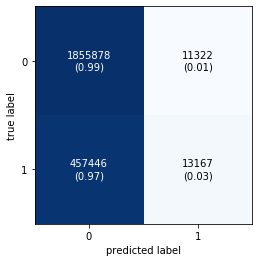

In [95]:
plot_confusion_matrix(cm, show_normed = True);

In [96]:
fpr, tpr, _ = metrics.roc_curve(y_test, y_test_pred_prob)

In [97]:
metrics.roc_auc_score(y_test, y_test_pred_prob)

0.6360648844168897

Text(0.5, 1.0, 'ROC curve')

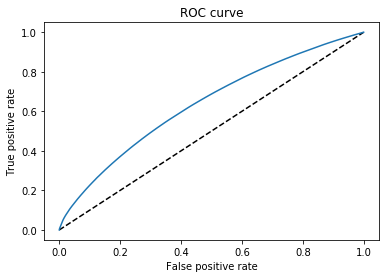

In [98]:
plt.plot([0,1], [0,1], 'k--')
plt.plot(fpr, tpr)
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve')

In [99]:
candidate_test_acc = .0
count = len(cutoffs) - 1
print_count = 100
for start_idx, end_idx in zip(cutoffs, cutoffs[1:]):
    probs = y_test_pred_prob[start_idx:end_idx]
    #if np.argmax(probs) == len(probs) - 1:
    if max(probs) == probs[-1]:
        if np.random.randint(sum(probs == probs[-1])) == 0:
            candidate_test_acc += 1
    else:
        if print_count:
            print(probs[-1], max(probs))
            print_count -= 1
candidate_test_acc /= count

In [100]:
candidate_test_acc

0.3558677724584744

In [28]:
graph_input.shape

(11793058, 250)

In [62]:
inp2 = Input(shape = (graph_train.shape[1], ))
# inp3 = Input(shape = (doc_input.shape[1], ))
w = inp2
w = Dense(256, activation = 'relu')(w)
w = Dropout(0.2)(w)
out = Dense(1, activation = 'sigmoid')(w)
model = Model(inputs=[inp2], outputs=out)
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_7 (InputLayer)         (None, 250)               0         
_________________________________________________________________
dense_7 (Dense)              (None, 256)               64256     
_________________________________________________________________
dropout_6 (Dropout)          (None, 256)               0         
_________________________________________________________________
dense_8 (Dense)              (None, 1)                 257       
Total params: 64,513
Trainable params: 64,513
Non-trainable params: 0
_________________________________________________________________


In [63]:
# model.fit([lstm_train, graph_train, doc_train], y_train, batch_size = 256, epochs = 3, validation_split = 0.2)
model.fit([graph_train], y_train, batch_size = 8192, epochs = 30, validation_split = 0.2, class_weight = weights)

Train on 7490784 samples, validate on 1872697 samples
Epoch 1/30
7490784/7490784 [==============================] - 9s 1us/step - loss: 0.4158 - acc: 0.8232 - val_loss: 0.3836 - val_acc: 0.8348
Epoch 2/30
7490784/7490784 [==============================] - 8s 1us/step - loss: 0.3851 - acc: 0.8342 - val_loss: 0.3719 - val_acc: 0.8394
Epoch 3/30
7490784/7490784 [==============================] - 8s 1us/step - loss: 0.3779 - acc: 0.8369 - val_loss: 0.3670 - val_acc: 0.8411
Epoch 4/30
7490784/7490784 [==============================] - 8s 1us/step - loss: 0.3738 - acc: 0.8385 - val_loss: 0.3632 - val_acc: 0.8430
Epoch 5/30
7490784/7490784 [==============================] - 8s 1us/step - loss: 0.3709 - acc: 0.8396 - val_loss: 0.3607 - val_acc: 0.8440
Epoch 6/30
7490784/7490784 [==============================] - 8s 1us/step - loss: 0.3688 - acc: 0.8405 - val_loss: 0.3592 - val_acc: 0.8444
Epoch 7/30
7490784/7490784 [==============================] - 8s 1us/step - loss: 0.3671 - acc: 0.8412 - v

In [82]:
# y_test_pred = model.predict([lstm_test, graph_test, doc_test])

# perfomance without knowledge graph embedding

y_test_pred_prob = model.predict([graph_test])

y_test_pred = np.where(y_test_pred_prob > 0.5, 1, 0)
accuracy_score(y_test, y_test_pred)

0.8503229300204935

In [83]:
cm = confusion_matrix(y_test, y_test_pred)

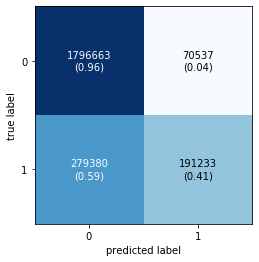

In [84]:
plot_confusion_matrix(cm, show_normed = True);

In [85]:
fpr, tpr, _ = metrics.roc_curve(y_test, y_test_pred_prob)

In [86]:
metrics.roc_auc_score(y_test, y_test_pred_prob)

0.8621347084016182

Text(0.5, 1.0, 'ROC curve')

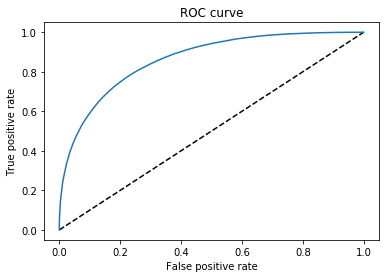

In [87]:
plt.plot([0,1], [0,1], 'k--')
plt.plot(fpr, tpr)
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve')

In [88]:
candidate_test_acc = .0
count = len(cutoffs) - 1
print_count = 100
for start_idx, end_idx in zip(cutoffs, cutoffs[1:]):
    probs = y_test_pred_prob[start_idx:end_idx]
    #if np.argmax(probs) == len(probs) - 1:
    if max(probs) == probs[-1]:
        if np.random.randint(sum(probs == probs[-1])) == 0:
            candidate_test_acc += 1
    else:
        if print_count:
            print(probs[-1], max(probs))
            print_count -= 1
candidate_test_acc /= count

[0.10663849] [0.21659997]
[0.15073198] [0.20447108]
[0.02454388] [0.333121]
[0.20760688] [0.5531492]
[0.27174062] [0.31035823]
[0.2743048] [0.52534866]
[0.04032218] [0.24748713]
[0.30647624] [0.393618]
[0.28649652] [0.42994094]
[0.24155119] [0.43789852]
[0.21499088] [0.29324704]
[0.22514299] [0.43782756]
[0.3787086] [0.5718919]
[0.1199792] [0.36397743]
[0.11733639] [0.16777924]
[0.11471987] [0.44338456]
[0.27232975] [0.593252]
[0.11515388] [0.3145296]
[0.28729564] [0.7646096]
[0.14040726] [0.19897676]
[0.30483726] [0.49834338]
[0.18419927] [0.3489733]
[0.05136034] [0.26318687]
[0.10435221] [0.18540221]
[0.12763667] [0.42356098]
[0.09033132] [0.71793526]
[0.30643654] [0.43717554]
[0.10352471] [0.26613644]
[0.19912037] [0.22046936]
[0.18573564] [0.28898227]
[0.11680326] [0.1347022]
[0.3960596] [0.43939933]
[0.20443588] [0.2801205]
[0.17167333] [0.22688803]
[0.22127089] [0.32030404]
[0.11636564] [0.39895278]
[0.36752796] [0.66682017]
[0.15450078] [0.6628461]
[0.6533886] [0.82122916]
[0.16

In [89]:
candidate_test_acc

0.6894943403603385

In [40]:
# y_test_pred = model.predict([lstm_test, graph_test, doc_test])

# perfomance without word embedding

y_test_pred = model.predict([graph_test])

y_test_pred = np.where(y_test_pred > 0.5, 1, 0)
accuracy_score(y_test, y_test_pred)

0.8411214731375911

In [41]:
cm = confusion_matrix(y_test, y_test_pred)

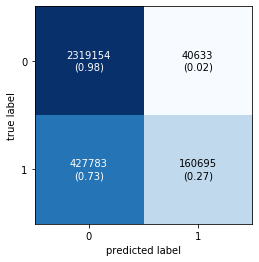

In [42]:
plot_confusion_matrix(cm, show_normed = True);

In [ ]:
# retrain new model

In [107]:
inp1 = Input(shape = (lstm_input.shape[1], ))
inp2 = Input(shape = (graph_input.shape[1], ))
# inp3 = Input(shape = (doc_input.shape[1], ))
embed = Embedding(output_dim=100, input_dim=len(word2idx), input_length=lstm_input.shape[1])(inp1)
out1 = LSTM(128)(embed)
w = concatenate([out1, inp2])
w = Dense(256, activation = 'relu')(w)
w = Dropout(0.2)(w)
out = Dense(1, activation = 'sigmoid')(w)
model = Model(inputs=[inp1, inp2], outputs=out)
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_19 (InputLayer)           (None, 20)           0                                            
__________________________________________________________________________________________________
embedding_10 (Embedding)        (None, 20, 100)      44588100    input_19[0][0]                   
__________________________________________________________________________________________________
lstm_10 (LSTM)                  (None, 128)          117248      embedding_10[0][0]               
__________________________________________________________________________________________________
input_20 (InputLayer)           (None, 250)          0                                            
__________________________________________________________________________________________________
concatenat

In [108]:
# model.fit([lstm_train, graph_train, doc_train], y_train, batch_size = 256, epochs = 3, validation_split = 0.2)
model.fit([lstm_train, graph_train], y_train, batch_size = 8192, epochs = 4, validation_split = 0.2, class_weight = weights)

Train on 7075834 samples, validate on 1768959 samples
Epoch 1/4


ResourceExhaustedError: 2 root error(s) found.
  (0) Resource exhausted: OOM when allocating tensor with shape[512] and type float on /job:localhost/replica:0/task:0/device:GPU:0 by allocator GPU_0_bfc
	 [[{{node training_11/Adam/mul_16}}]]
Hint: If you want to see a list of allocated tensors when OOM happens, add report_tensor_allocations_upon_oom to RunOptions for current allocation info.

	 [[metrics_11/acc/Mean_1/_1673]]
Hint: If you want to see a list of allocated tensors when OOM happens, add report_tensor_allocations_upon_oom to RunOptions for current allocation info.

  (1) Resource exhausted: OOM when allocating tensor with shape[512] and type float on /job:localhost/replica:0/task:0/device:GPU:0 by allocator GPU_0_bfc
	 [[{{node training_11/Adam/mul_16}}]]
Hint: If you want to see a list of allocated tensors when OOM happens, add report_tensor_allocations_upon_oom to RunOptions for current allocation info.

0 successful operations.
0 derived errors ignored.

In [ ]:
# y_test_pred = model.predict([lstm_test, graph_test, doc_test])
y_test_pred_prob = model.predict([lstm_test, graph_test])

y_test_pred = np.where(y_test_pred_prob > 0.5, 1, 0)
accuracy_score(y_test, y_test_pred)

In [ ]:
cm = confusion_matrix(y_test, y_test_pred)

In [ ]:
from mlxtend.plotting import plot_confusion_matrix

plot_confusion_matrix(cm, show_normed = True);

In [ ]:
metrics.roc_auc_score(y_test, y_test_pred_prob)

In [ ]:
fpr, tpr, _ = metrics.roc_curve(y_test, y_test_pred_prob)

In [ ]:
plt.plot([0,1], [0,1], 'k--')
plt.plot(fpr, tpr)
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve')

In [96]:
# inp1 = Input(shape = (lstm_input.shape[1], ))
# inp2 = Input(shape = (graph_input.shape[1], ))
# # inp3 = Input(shape = (doc_input.shape[1], ))
# embed = Embedding(output_dim=128, input_dim=len(word2idx), input_length=lstm_input.shape[1])(inp1)
# out1 = LSTM(128)(embed)
# w = concatenate([out1, inp2])
# w = Dense(128, activation = 'relu')(w)
# w = Dropout(0.2)(w)
# w = Dense(64, activation = 'relu')(w)
# w = Dropout(0.2)(w)
# w = Dense(32, activation = 'relu')(w)
# w = Dropout(0.2)(w)
# out = Dense(1, activation = 'sigmoid')(w)
# model = Model(inputs=[inp1, inp2], outputs=out)
# model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
# model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_15 (InputLayer)           (None, 20)           0                                            
__________________________________________________________________________________________________
embedding_8 (Embedding)         (None, 20, 128)      57072768    input_15[0][0]                   
__________________________________________________________________________________________________
lstm_8 (LSTM)                   (None, 128)          131584      embedding_8[0][0]                
__________________________________________________________________________________________________
input_16 (InputLayer)           (None, 250)          0                                            
__________________________________________________________________________________________________
concatenat

In [97]:
# # model.fit([lstm_train, graph_train, doc_train], y_train, batch_size = 256, epochs = 3, validation_split = 0.2)
# model.fit([lstm_train, graph_train], y_train, batch_size = 8192, epochs = 4, validation_split = 0.2, class_weight = weights)

Train on 7075834 samples, validate on 1768959 samples
Epoch 1/4
7075834/7075834 [==============================] - 248s 35us/step - loss: 0.4011 - acc: 0.8251 - val_loss: 0.3412 - val_acc: 0.8467
Epoch 2/4
7075834/7075834 [==============================] - 244s 35us/step - loss: 0.3334 - acc: 0.8494 - val_loss: 0.3199 - val_acc: 0.8555
Epoch 3/4
7075834/7075834 [==============================] - 244s 35us/step - loss: 0.3016 - acc: 0.8619 - val_loss: 0.3136 - val_acc: 0.8583
Epoch 4/4
7075834/7075834 [==============================] - 245s 35us/step - loss: 0.2769 - acc: 0.8727 - val_loss: 0.3205 - val_acc: 0.8580


In [98]:
# y_test_pred = model.predict([lstm_test, graph_test, doc_test])
y_test_pred_prob = model.predict([lstm_test, graph_test])

y_test_pred = np.where(y_test_pred_prob > 0.5, 1, 0)
accuracy_score(y_test, y_test_pred)

0.8578384236152449

In [100]:
cm = confusion_matrix(y_test, y_test_pred)

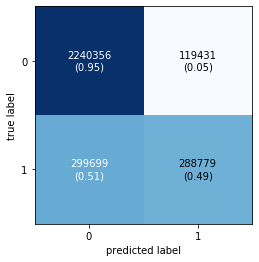

In [101]:
from mlxtend.plotting import plot_confusion_matrix

plot_confusion_matrix(cm, show_normed = True);

In [102]:
metrics.roc_auc_score(y_test, y_test_pred_prob)

0.8862756502902215

In [103]:
fpr, tpr, _ = metrics.roc_curve(y_test, y_test_pred_prob)

Text(0.5, 1.0, 'ROC curve')

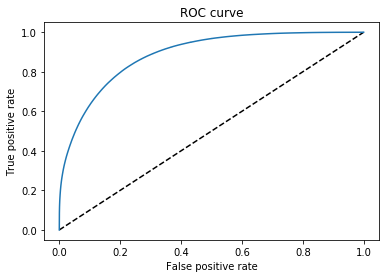

In [104]:
plt.plot([0,1], [0,1], 'k--')
plt.plot(fpr, tpr)
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve')

In [ ]:
def compute_abstain_threshold()

In [72]:
print('hi')

hi


In [ ]:
def 

In [40]:
# model.save('../data/model1/model.h5')

# np.save("../data/model1/lstm_train", lstm_train)
# np.save("../data/model1/lstm_iest", lstm_test)

# np.save("../data/model1/graph_train", graph_train)
# np.save("../data/model1/graph_test", graph_test)

# np.save("../data/model1/y_train", y_train)
# np.save("../data/model1/y_test", y_test)

In [ ]:
# y_test_pred = model.predict([lstm_test, graph_test, doc_test])
y_test_pred = model.predict([lstm_test, graph_test])

y_test_pred = np.where(y_test_pred > 0.25, 1, 0)
accuracy_score(y_test, y_test_pred)

In [ ]:
cm = confusion_matrix(y_test, y_test_pred)

In [ ]:
from mlxtend.plotting import plot_confusion_matrix

plot_confusion_matrix(cm, show_normed = True);